In [1]:
from textblob import TextBlob, Word
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
import csv
with open('data.csv', 'r', encoding='cp850') as f:   #This encoding 'cp850' is related to OS. On Windows, the encoding used by the console (thus, that of sys.stdin/out) differs from the encoding of various OS-provided strings - obtained through e.g. os.getenv(), sys.argv, and certainly many more.
  reader = csv.reader(f)
  result = list(reader) #Putting them all in a list
print(result[1:5])

[['A few mistakes here and there, but overall a good service.'], ['A good option for a restaurant like meal at home. Nice selection of entrees, delivery service is very good.'], ['A lot of the food is good however, what I find most annoying is the photos show more food than you actually receive. I was thrilled to see more salads but disappointed when they arrived.'], ["All the items I've bought from Munchery have been good, and some of them have been excellent. And they arrive on time. I wish they had dessert, but I'm better off without it."]]


In [3]:
#Converting the lists of list to single list with all the reviews as elements of the list.
from itertools import chain
result2 = list(chain.from_iterable(result))
result2[1:5]

[' well-priced and creatively offered on the menu. Menus change at the right pace. Deliveries are on time and accurate."',
 'A few mistakes here and there, but overall a good service.',
 'A good option for a restaurant like meal at home. Nice selection of entrees, delivery service is very good.',
 'A lot of the food is good however, what I find most annoying is the photos show more food than you actually receive. I was thrilled to see more salads but disappointed when they arrived.']

In [4]:
# Text cleaning 
from string import punctuation
import re

def clean_sentence(sentence):
    sentence = re.sub(r"(?:\@|https?\://)\S+|\n+", "", sentence.lower()) #Converts every upper case letter to lower one and unalters lower case letters.
    sent = TextBlob(sentence)
    sent.correct() #Correcting spelling errors
    clean = ""
    for sentence in sent.sentences:    
        words = sentence.words
        # Remove punctuations
        words = [''.join(c for c in s if c not in punctuation) for s in words]
        words = [s for s in words if s]
        clean += " ".join(words)
        clean += ". "
    return clean

result2 = [clean_sentence(x) for x in result2]
result2[5]

'all the items i ve bought from munchery have been good and some of them have been excellent. and they arrive on time. i wish they had dessert but i m better off without it. '

In [5]:
# Check sentiment polarity of each sentence.
sentiment_scores = list()
i = 0
for sentence in result2:
    line = TextBlob(sentence)
    polaritycalucalated = ((line.sentiment.polarity)+1)/2    #Changing the polarity scale from (-1~1) to (0~1)
    sentiment_scores.append(polaritycalucalated)
    if(i <= 10):
        print(sentence + ": POLARITY=" + str(polaritycalucalated))
        i += 1

´╗┐ 5 stars. food is excellent. : POLARITY=1.0
wellpriced and creatively offered on the menu. menus change at the right pace. deliveries are on time and accurate. : POLARITY=0.6976190476190476
a few mistakes here and there but overall a good service. : POLARITY=0.5833333333333334
a good option for a restaurant like meal at home. nice selection of entrees delivery service is very good. : POLARITY=0.8683333333333334
a lot of the food is good however what i find most annoying is the photos show more food than you actually receive. i was thrilled to see more salads but disappointed when they arrived. : POLARITY=0.578125
all the items i ve bought from munchery have been good and some of them have been excellent. and they arrive on time. i wish they had dessert but i m better off without it. : POLARITY=0.8666666666666667
always great. : POLARITY=0.9
always wonderful food. always courteous delivery people. i recommend munchery without reservation. : POLARITY=0.9
consistently delicious seems h

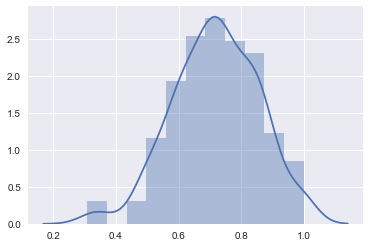

In [6]:
# Let's plot these sentiments!
sns.distplot(sentiment_scores)

In [7]:
# Convert array of comments into a single string
comments = TextBlob(' '.join(result2))

In [8]:
# Check out noun phrases, will be useful for frequent feature extraction
comments.noun_phrases

WordList(['right pace', 'good service', 'good option', 'nice selection', 'entrees delivery service', 'items i ve', 'i m', 'wonderful food', 'courteous delivery people', 'healthy plenty', 'convenience good food', 'convenient delicious', 'tasty healthy', 'delicious food restaurant quality punctual delivery', 'great communication email', 'easy instructions', 'delicious meals', 'i ca nt complain', 'delicious nutritious food', 'great customer service', 'simple process', 'food quality good', 'excelent service', 'great portion taste delivery', 'point \xadƒöî\xadƒå╗\xadƒöî\xadƒå╗', 'innovative menu items', 'excellent food', 'delivery service', 'excellent food', 'excellent quality food', 'great service', 'fair price', 'meal service i havenôçöt', 'excellent service good communication food quality high', 'plastic containers', 'tastes delicious', 'i appreaciate', 'fresh ingredients', 'worthless w high prices┬áno organic food', 'hard time', 'lack texture', 'food tastes', 'i ve', 'customer service',

In [9]:
#compactness pruning:
cleaned = list()
for phrase in comments.noun_phrases:
    count = 0
    for word in phrase.split():
        # Count the number of small words and words without an English definition
        if len(word) <= 2 or (not Word(word).definitions):
            count += 1
    # Only if the 'nonsensical' or short words DO NOT make up more than 40% (arbitrary) of the phrase add
    # it to the cleaned list, effectively pruning the ones not added.
    if count < len(phrase.split())*0.4:
        cleaned.append(phrase)
        
print("After compactness pruning:\nFeature Size:")
len(cleaned)

After compactness pruning:
Feature Size:


249

In [10]:
for phrase in cleaned:    
    match = list()
    temp = list()
    word_match = list()
    for word in phrase.split():
        # Find common words among all phrases
        word_match = [p for p in cleaned if re.search(word, p) and p not in word_match]
        # If the size of matched phrases set is smaller than 30% of the cleaned phrases, 
        # then consider the phrase as non-redundant.
        if len(word_match) <= len(cleaned)*0.3 :
            temp.append(word)
            match += word_match
            
    phrase = ' '.join(temp)
#     print("Match for " + phrase + ": " + str(match))

    if len(match) >= len(cleaned)*0.1 :
        # Redundant feature set, since it contains more than 10% of the number of phrases. 
        # Prune all matched features.
        for feature in match:
            if feature in cleaned:
                cleaned.remove(feature)
            
        # Add largest length phrase as feature
        cleaned.append(max(match, key=len))
        

print("After redundancy pruning:\nFeature Size:" + str(len(cleaned)))
print("Cleaned features:")
cleaned

After redundancy pruning:
Feature Size:86
Cleaned features:


['right pace',
 'nice selection',
 'easy instructions',
 'simple process',
 'innovative menu items',
 'fair price',
 'plastic containers',
 'fresh ingredients',
 'hard time',
 'lack texture',
 'execution component tends',
 'fatty meat',
 'old favorites',
 'clear instructions',
 'fresh ingredients tasty',
 'easy prep',
 'meal prep kits',
 'philadelphia cheese steak sandwich',
 'own home',
 'lemon lime wedges',
 'pretty high sodium content',
 'star downgrade',
 'reasonable pricing',
 'huge help',
 'grocery store deli',
 'fresh ingredients',
 'solves dinner',
 'minimal effort',
 'stomach issues',
 'reasonable prices',
 'portion size',
 'long day',
 'subtle seasonings',
 'gift certificate',
 'different items i',
 'top notch',
 'inviting menu',
 'excellent preparation',
 'optional tip',
 'different places',
 'big increase',
 'nutritional values',
 'perfect side portion',
 'nice dinner',
 'kitchen cooking',
 'certain items',
 'healthier option',
 'own cooking',
 'meal planning',
 'busy paren

In [11]:
from nltk.corpus import stopwords
feature_count = dict()
for phrase in cleaned:
    count = 0
    for word in phrase.split():
        if word not in stopwords.words('english'):
            count += comments.words.count(word)
    
    print(phrase + ": " + str(count))
    feature_count[phrase] = count

right pace: 6
nice selection: 8
easy instructions: 21
simple process: 4
innovative menu items: 17
fair price: 9
plastic containers: 2
fresh ingredients: 21
hard time: 30
lack texture: 2
execution component tends: 3
fatty meat: 2
old favorites: 5
clear instructions: 5
fresh ingredients tasty: 34
easy prep: 20
meal prep kits: 21
philadelphia cheese steak sandwich: 6
own home: 7
lemon lime wedges: 3
pretty high sodium content: 16
star downgrade: 4
reasonable pricing: 8
huge help: 5
grocery store deli: 3
fresh ingredients: 21
solves dinner: 10
minimal effort: 2
stomach issues: 3
reasonable prices: 18
portion size: 10
long day: 8
subtle seasonings: 2
gift certificate: 2
different items i: 11
top notch: 3
inviting menu: 9
excellent preparation: 23
optional tip: 2
different places: 4
big increase: 4
nutritional values: 2
perfect side portion: 14
nice dinner: 13
kitchen cooking: 9
certain items: 9
healthier option: 4
own cooking: 8
meal planning: 18
busy parents everywhere: 7
reasonable price:

In [12]:
# Select frequent feature threshold as (max_count)/100 
# This is an arbitrary decision as of now.
counts = list(feature_count.values())
features = list(feature_count.keys())
threshold = len(comments.noun_phrases)/100

print("Threshold:" + str(threshold))

frequent_features = list()

for feature, count in feature_count.items():
    if count >= threshold:
        frequent_features.append(feature)
        
print('Frequent Features:')
frequent_features

Threshold:3.21
Frequent Features:


['right pace',
 'nice selection',
 'easy instructions',
 'simple process',
 'innovative menu items',
 'fair price',
 'fresh ingredients',
 'hard time',
 'old favorites',
 'clear instructions',
 'fresh ingredients tasty',
 'easy prep',
 'meal prep kits',
 'philadelphia cheese steak sandwich',
 'own home',
 'pretty high sodium content',
 'star downgrade',
 'reasonable pricing',
 'huge help',
 'solves dinner',
 'reasonable prices',
 'portion size',
 'long day',
 'different items i',
 'inviting menu',
 'excellent preparation',
 'different places',
 'big increase',
 'perfect side portion',
 'nice dinner',
 'kitchen cooking',
 'certain items',
 'healthier option',
 'own cooking',
 'meal planning',
 'busy parents everywhere',
 'reasonable price',
 'busy family',
 'salads yogurt',
 'yogurt parfait',
 'dry salad',
 'huge sides',
 'excellent kids menu',
 'reliable deliveries',
 'time line',
 'bit dry',
 'new world stuff',
 'busy parents',
 'vegetarian choices',
 'hot spices',
 'easy directions',

In [13]:
absa_list = dict()
# For each frequent feature
for f in frequent_features:
    # For each comment
    absa_list[f] = list()
    for comment in result2:
        blob = TextBlob(comment)
        # For each sentence of the comment
        for sentence in blob.sentences:
            # Search for frequent feature 'f'
            q = '|'.join(f.split())
            if re.search(r'\w*(' + str(q) + ')\w*', str(sentence)):
                absa_list[f].append(sentence)


#print("Aspect Specific sentences:")
#absa_list

In [14]:
scores = list()
absa_scores = dict()
for k, v in absa_list.items():
    absa_scores[k] = list()
    for sent in v:
        score = (sent.sentiment.polarity+1)/2 #Changing the polarity scale from (-1~1) to (0~1)
        scores.append(score)
        absa_scores[k].append(score)

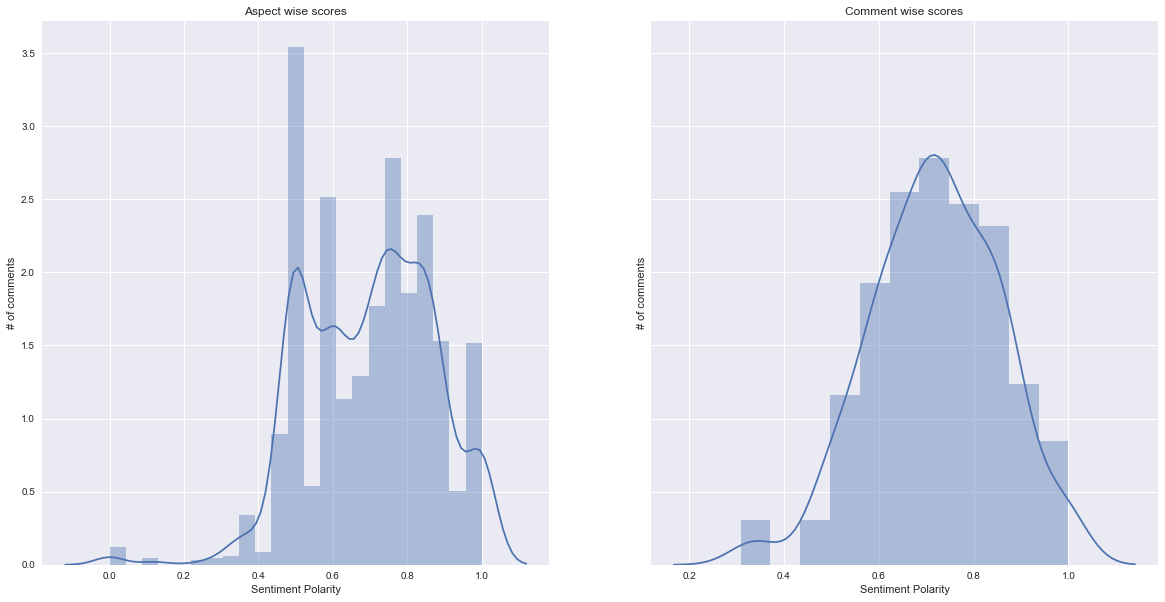

In [15]:
# Now that we have all the scores, let's plot them!
# For comparison, we replot the previous global sentiment polarity plot
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(20, 10))
plot1 = sns.distplot(scores, ax=ax1)

ax1.set_title('Aspect wise scores')
ax1.set_xlabel('Sentiment Polarity')
ax1.set_ylabel('# of comments')

ax2.set_title('Comment wise scores')
ax2.set_xlabel('Sentiment Polarity')
ax2.set_ylabel('# of comments')

plot2 = sns.distplot(sentiment_scores, ax=ax2)

In [16]:
# Create data values for stripplot and boxplot
vals = dict()
vals["aspects"] = list()
vals["scores"] = list()
for k, v in absa_scores.items():
    for score in v:
        vals["aspects"].append(k)
        vals["scores"].append(score)

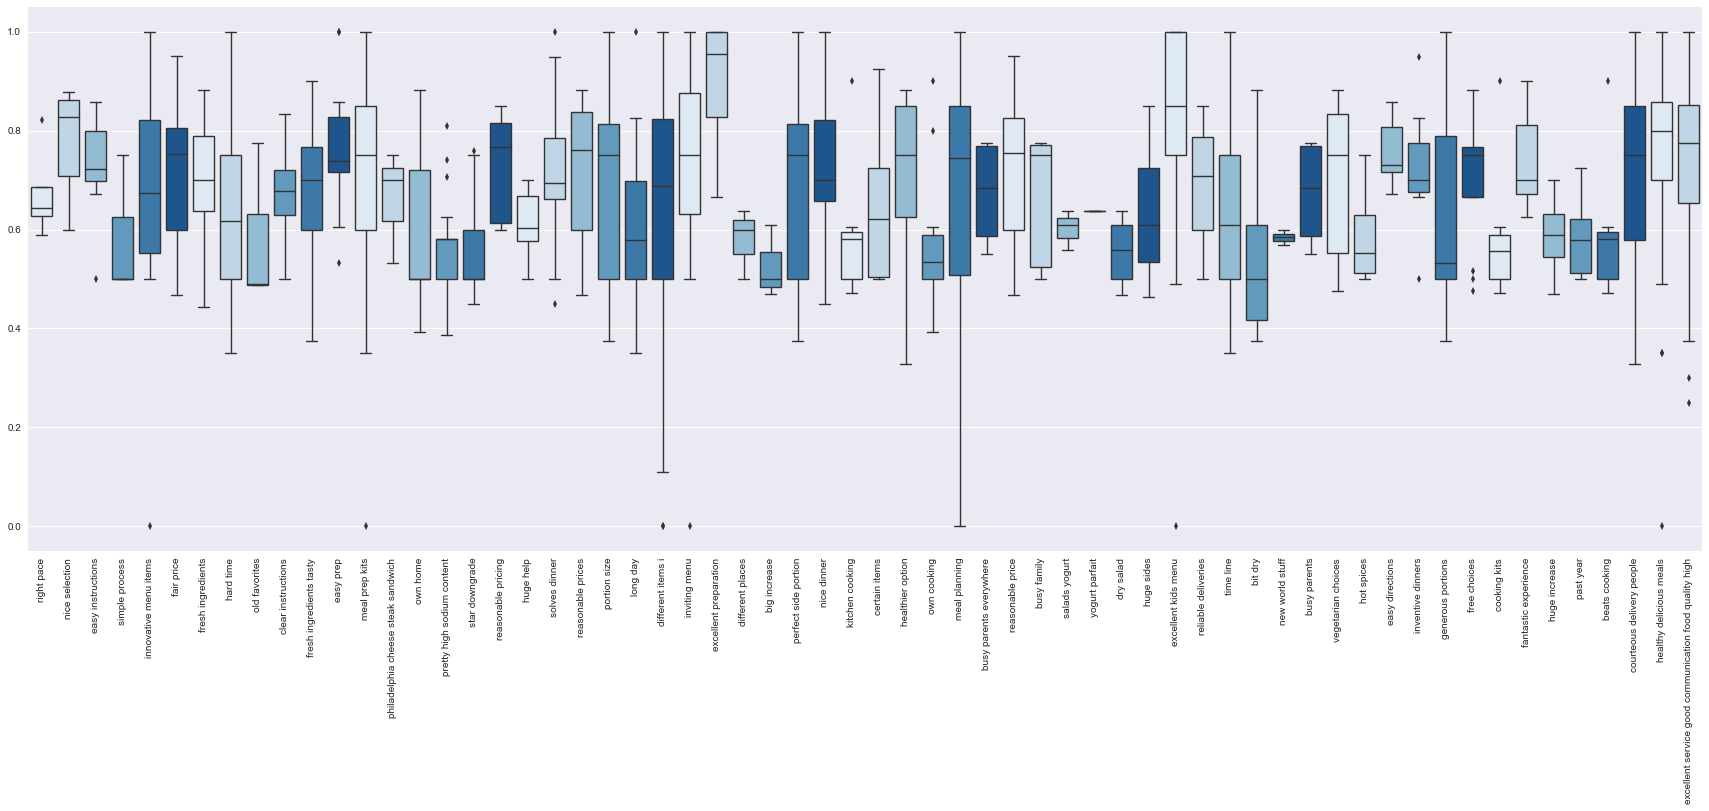

In [17]:
fig, ax1 = plt.subplots(figsize=(30, 10))

color = sns.color_palette("Blues", 6)
plt.xticks(rotation=90)
sns.set_context("paper", font_scale=3) 
sns.boxplot(x="aspects", y="scores", data=vals, palette=color, ax=ax1)

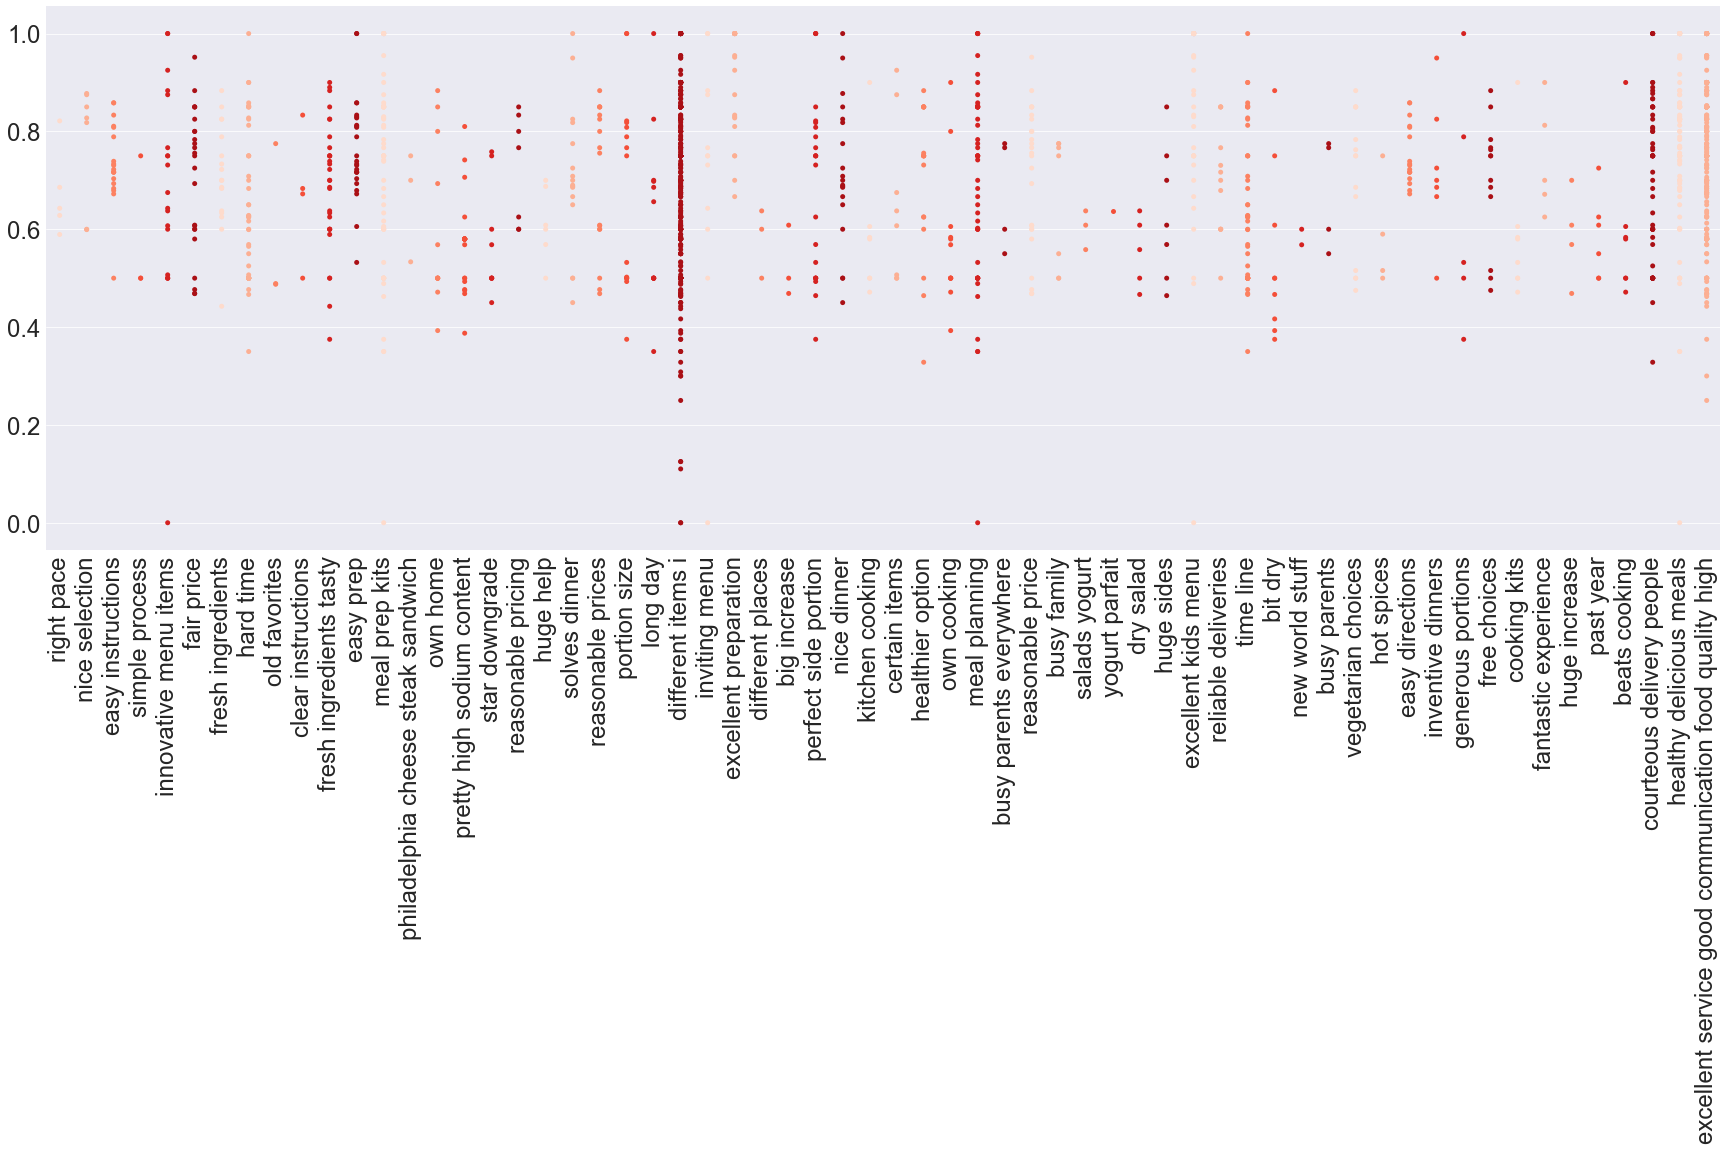

In [18]:
color = sns.color_palette("Reds", 6)
fig, ax1 = plt.subplots(figsize=(30, 10))
plt.xticks(rotation=90)
sns.set_context("paper", font_scale=2) 
sns.stripplot(x="aspects", y="scores",data=vals, palette=color)